# TFM: Sistema de soporte a las decisiones para invertir en el mercado de valores mediante el uso de predictiva analítica

# Preparación entorno Spark


---






In [1]:
#Agregar variables de entorno JAVA y SPARK
import os
os.environ["SPARK_HOME"] = "/Users/marc/spark-3.1.1-bin-hadoop2.7"
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_261.jdk/Contents/Home"

In [2]:
import pandas as pd
import numpy as np

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.types import *
from pyspark.mllib.stat import Statistics
conf = pyspark.SparkConf().setAppName('spark_app').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

## Carga del dataset

In [5]:
df = pd.read_csv("dataset.csv", sep=",")
df.head(5)

,Year,CID,Currency,Exchange,Exchange Name,Industry,Next year price,Company Name,Revenues,Depreciation & Amortization,...,Interest Expense,Income Tax Expense,Weighted Average Diluted Shares Outstanding,Capital Expenditure,Cash And Equivalents,Current Portion of Long-Term Debt,Long-Term Debt,Goodwill,Total Equity,Cash Flow per Share
0,2015.0,25307.0,USD,NYSE,New York Stock Exchange,Specialty Retail,789.79,"AutoZone, Inc.",10187.340,269.919,...,-152.044,-642.371,32.206,-480.579,175.309,NaN,4624.876,391.887,-1701.390,34.298
1,2016.0,25307.0,USD,NYSE,New York Stock Exchange,Specialty Retail,711.37,"AutoZone, Inc.",10635.676,297.397,...,-150.052,-671.707,30.488,-488.791,189.734,NaN,4924.119,391.887,-1787.538,38.217
2,2017.0,25307.0,USD,NYSE,New York Stock Exchange,Specialty Retail,838.34,"AutoZone, Inc.",10888.676,323.051,...,-158.082,-644.620,29.065,-553.832,293.270,NaN,5081.238,391.887,-1428.377,35.764
3,2018.0,25307.0,USD,NYSE,New York Stock Exchange,Specialty Retail,1191.31,"AutoZone, Inc.",11221.077,345.084,...,-180.163,-298.793,27.424,-521.788,217.824,NaN,5005.930,302.645,-1520.355,57.787
4,2019.0,25307.0,USD,NYSE,New York Stock Exchange,Specialty Retail,1185.44,"AutoZone, Inc.",11863.743,365.757,...,-192.200,-414.112,25.498,-496.050,176.300,NaN,5206.344,302.645,-1713.851,65.387


In [6]:
df.describe()

,Year,CID,Next year price,Revenues,Depreciation & Amortization,Operating Income,Interest Expense,Income Tax Expense,Weighted Average Diluted Shares Outstanding,Capital Expenditure,Cash And Equivalents,Current Portion of Long-Term Debt,Long-Term Debt,Goodwill,Total Equity,Cash Flow per Share
count,1304.000000,1.304000e+03,1294.000000,1248.000000,1261.000000,1283.000000,1189.000000,1253.000000,1296.000000,1206.000000,1303.000000,1014.000000,1193.000000,1128.000000,1303.000000,1295.00000
mean,2018.021472,1.566154e+07,2015.886371,14568.279345,0.862826,2757.204950,-347.159306,-557.134868,439.882614,-983.953765,3582.348117,631.298983,8474.660491,5707.426774,14337.186190,88.80531
std,2.006015,7.294345e+07,25184.033669,28915.325276,2176.018855,7453.647613,984.422573,1962.951531,1011.309283,2749.867766,19291.574325,1388.282687,18771.696459,11086.596813,42277.379537,1138.54101
min,2015.000000,1.960900e+04,1.310000,-0.400000,-20998.000000,-5723.000000,-18852.000000,-26774.000000,0.250000,-26490.000000,0.434000,0.001000,0.239000,0.355000,-11476.000000,-62.94200
25%,2016.000000,3.604000e+04,63.555000,2879.254750,-170.000000,515.508500,-273.000000,-416.300000,82.445000,-600.500000,191.438500,19.000000,1409.500000,665.700000,1670.842000,2.58750
50%,2018.000000,2.687990e+05,112.095000,5938.271500,69.046000,945.700000,-124.000000,-187.667000,135.834500,-233.336500,584.100000,246.673000,3396.000000,2105.000000,3846.600000,4.86800
75%,2020.000000,3.568050e+05,203.797500,11857.637250,242.156000,1963.448000,-50.100000,-59.600000,240.096500,-88.850000,1872.288500,579.500000,7329.470000,5173.000000,8651.061000,8.55300
max,2022.000000,6.362019e+08,416580.000000,279332.000000,12905.000000,136721.000000,-0.002000,21515.000000,8254.000000,-0.147000,344322.000000,24412.000000,193058.000000,81882.000000,478800.000000,20685.69200


In [7]:
df.count()

Year                                           1304
CID                                            1304
Currency                                       1305
Exchange                                       1305
Exchange Name                                  1305
Industry                                       1305
Next year price                                1294
Company Name                                   1305
Revenues                                       1248
Depreciation & Amortization                    1261
Operating Income                               1283
Interest Expense                               1189
Income Tax Expense                             1253
Weighted Average Diluted Shares Outstanding    1296
Capital Expenditure                            1206
Cash And Equivalents                           1303
Current Portion of Long-Term Debt              1014
Long-Term Debt                                 1193
Goodwill                                       1128
Total Equity

## Corrección de valores faltantes

Añadimos 0 a algunas de las celdas vacías ya que no tienen deuda y por lo tanto es 0
y hacemos lo mismo con el Goodwill y con el Capital Expenditure

In [8]:

df['Current Portion of Long-Term Debt'] = df['Current Portion of Long-Term Debt'].fillna(0)
df['Long-Term Debt'] = df['Long-Term Debt'].fillna(0)
df['Goodwill'] = df['Goodwill'].fillna(0)
df['Capital Expenditure'] = df['Capital Expenditure'].fillna(0)


Para realizar este estudio descartamos el año 2021 (en curso) y el 2020 por ser un año anómalo devido a la pandemia

In [9]:
cleandf = df.drop(df[df.Year == 2020].index)
cleandf = df.drop(df[df.Year == 2021].index)


Eliminación de registros con valores nulos

In [10]:
cleandf = df.dropna()

Observamos cuantas compañias por año tenemos disponibles al realizar la limpieza


In [11]:
cleandf.groupby('Year').count()

,CID,Currency,Exchange,Exchange Name,Industry,Next year price,Company Name,Revenues,Depreciation & Amortization,Operating Income,Interest Expense,Income Tax Expense,Weighted Average Diluted Shares Outstanding,Capital Expenditure,Cash And Equivalents,Current Portion of Long-Term Debt,Long-Term Debt,Goodwill,Total Equity,Cash Flow per Share
Year,,,,,,,,,,,,,,,,,,,,
2015.0,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143
2016.0,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
2017.0,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154
2018.0,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157
2019.0,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157
2020.0,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157,157
2021.0,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160


## Correlación de las variables

A continuación se muestra la matriz de correlación de las variables

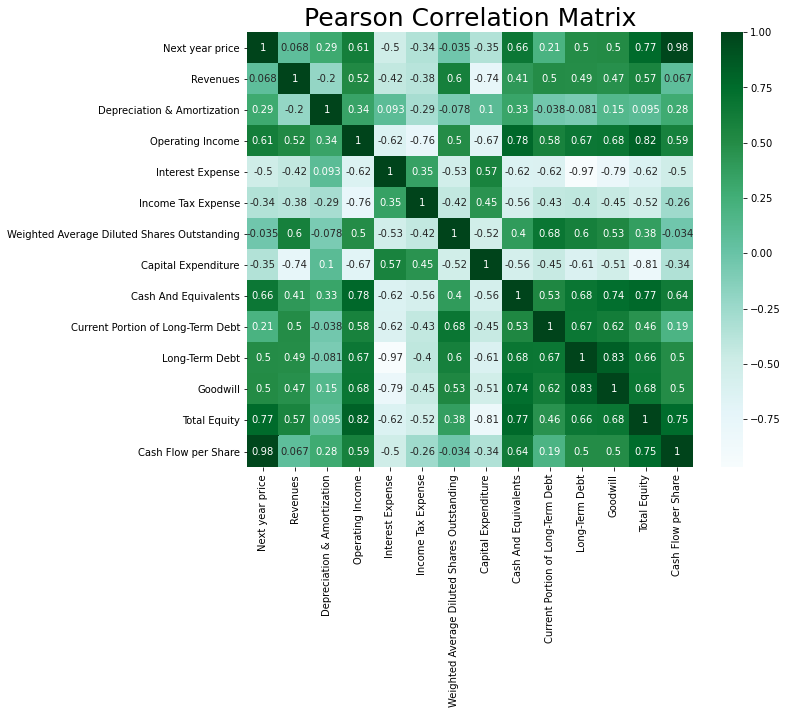

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)
features = ['Next year price', 'Industry', 'Revenues', 'Depreciation & Amortization', 'Operating Income', 
            'Interest Expense', 'Income Tax Expense', 'Weighted Average Diluted Shares Outstanding',
            'Capital Expenditure', 'Cash And Equivalents', 'Current Portion of Long-Term Debt', 'Long-Term Debt',
            'Goodwill', 'Total Equity', 'Cash Flow per Share']
corr = cleandf[features].corr()
sns.heatmap(corr, cmap="BuGn", annot=True)
plt.show()

Se ordena de mayor a menor correlacción y se muestra un total de 10 variables

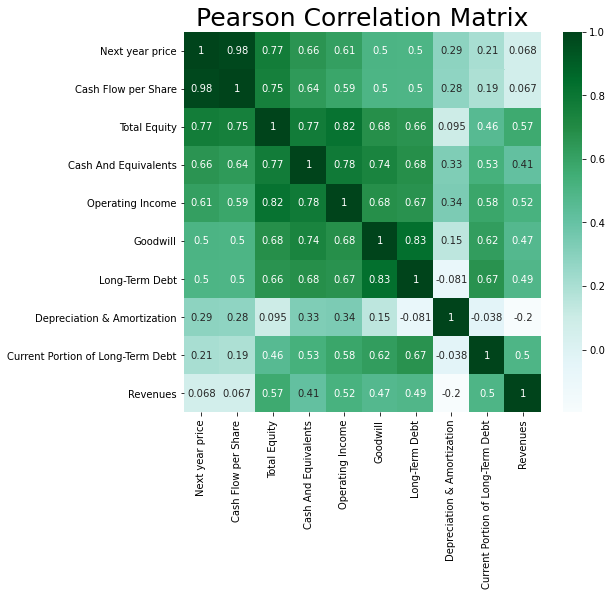

In [13]:
f, ax = plt.subplots(figsize=(8, 7))
plt.title('Pearson Correlation Matrix',fontsize=25)
top_corr = cleandf[features].corr()
top_corr = cleandf[corr["Next year price"].sort_values(ascending=False)[:10].index].corr()
sns.heatmap(top_corr, annot=True, cmap="BuGn")
plt.show()

Realizando el gráfico de correlación de Pearson observamos hay una fuerte correlación entre el precio y los siguientes ratios:

- Cash flow per share: 0.98
- Total equity: 0.77
- Cash and equivalents: 0.66
- Operating Income: 0.62
- Goodwill 0.5
- Long term debt: 0.5
    

Como podemos oberservar también existe una fuerte correlación entre ellas. Por lo tanto, la mejor práctica es seleccionar características que estén altamente correlacionadas con el precio, pero que no estén correlacionadas entre sí. Por ahora, elegiremos lo siguiente:
- Depreciation & Amortization
- Income Tax Expense
- Current Portion of Long-Term Debt
- Cash Flow per Share


Seleccionamos aquellas variables dependientes e independientes

In [14]:
# Independientes
x = cleandf[['Current Portion of Long-Term Debt', 
            'Cash Flow per Share']]
# Objetivo
y = cleandf[[ 'Next year price']]

## Separar datos de entrenamiento y test

Separamos los datos de entrenamiento de forma aleatoria, usamos un 30% de los datos para test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    x, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

## Mínimos cuadrados ordinarios

Se comprueba si el R-squared se mantiene o disminuye con las variables anteriormente elegidas.
La mejor combinación la obtenemos con las variables:
- Current Portion of Long-Term Debt
- Cash Flow per Share  

In [16]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        Next year price   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.203e+05
Date:                Thu, 14 Oct 2021   Prob (F-statistic):                        0.00
Time:                        23:28:13   Log-Likelihood:                         -7598.8
No. Observations:                 862   AIC:                                  1.520e+04
Df Residuals:                     860   BIC:                                  1.521e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                        coef    std err          t      P>|t|      [0.025      0.975]
------------------

## Outliers

Se comprueba visualmente si existen outliers. En este caso se pueden observar que algunos puntos se ecuentrán fuera.

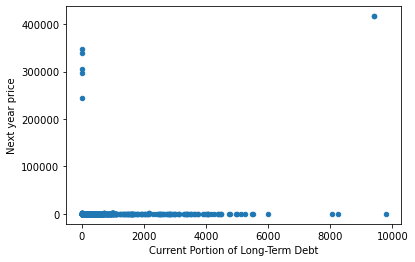

In [17]:
cleandf[['Current Portion of Long-Term Debt','Next year price']].plot.scatter(y='Next year price', x='Current Portion of Long-Term Debt')
plt.show()

Se realiza el mismo proceso con la varible cashflow

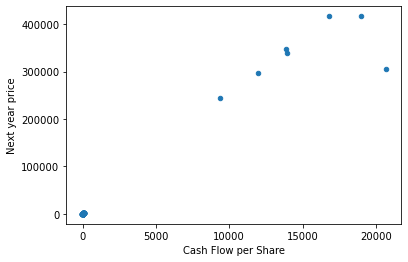

In [18]:
cleandf[['Cash Flow per Share','Next year price']].plot.scatter(y='Next year price', x='Cash Flow per Share')
plt.show()

In [19]:
cleandf[cleandf['Next year price'] > 200000]['Next year price'].count()

7

In [20]:
outdf = cleandf[cleandf['Next year price'] < 1000]

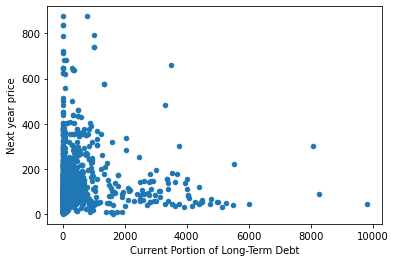

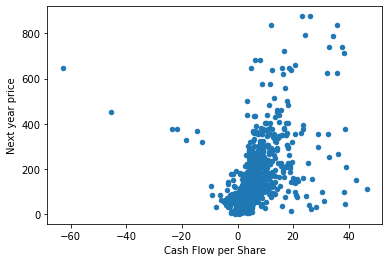

In [21]:
outdf[['Current Portion of Long-Term Debt','Next year price']].plot.scatter(y='Next year price', x='Current Portion of Long-Term Debt')
outdf[['Cash Flow per Share','Next year price']].plot.scatter(y='Next year price', x='Cash Flow per Share')
plt.show()

Se cargan otra vez los datos filtrados

## Función de evaluación

Función para evaluar los algoritmos

In [22]:
from sklearn import metrics
#create comparison table
df_statistics = pd.DataFrame(columns = ['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])

def evaluate(real, predicted, model_name):  
    mae = metrics.mean_absolute_error(real, predicted)
    mse = metrics.mean_squared_error(real, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(real, predicted))
    r2_square = metrics.r2_score(real, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)  
    global df_statistics
    new_model = {'Model':model_name, 'MAE':mae, 'MSE':mse, 'RMSE':rmse, 'R2 Square':r2_square}
    df_statistics = df_statistics.append(new_model, ignore_index=True)
    

## Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [24]:
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)
evaluate(y_test, test_pre , "Lineal regression")

MAE: 1118.582913136669
MSE: 169414142.21886247
RMSE: 13015.918800409845
R2 Square 0.7970756709295186


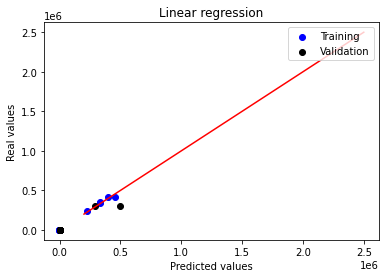

In [25]:
plt.scatter(train_pre, y_train, c = "blue",  label = "Training")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper right")
plt.plot([0.2*10**6, 0.25*10**7], [0.2*10**6, 0.25*10**7], c = "red")
plt.show()

## Support Vector Machine

In [26]:
from sklearn.svm import SVR
from math import sqrt


Testeamos los distintos kernels para ver con cual se obtiene mejores resultados

In [27]:
for k in ['linear','poly','rbf','sigmoid']:
    clf = SVR(kernel=k)
    clf.fit(X_train, np.ravel(y_train))
    confidence = clf.score(X_train, np.ravel(y_train))
    error = sqrt(metrics.mean_squared_error(y_test,clf.predict(X_test)))
    print(k,confidence, error)

linear 0.9950637593019964 14119.21229365513
poly 0.9230953546737453 55446.00365604829
rbf -0.006132805936485797 29034.333369606615
sigmoid -0.005940123181182644 29031.790837707063


Elegimos el que mayor coincidencia obtenemos

In [28]:
svr_linear = SVR(kernel='linear')
svr_linear.fit(X_train, np.ravel(y_train))
test_pre = svr_linear.predict(X_test)
train_pre = svr_linear.predict(X_train)
evaluate(y_test, test_pre, "Support Vector Machine - linear")


MAE: 1060.546510885231
MSE: 199352155.79330212
RMSE: 14119.21229365513
R2 Square 0.761215905984702


In [29]:
svr_linear = SVR(kernel='poly')
svr_linear.fit(X_train, np.ravel(y_train))
test_pre = svr_linear.predict(X_test)
train_pre = svr_linear.predict(X_train)
evaluate(y_test, test_pre, "Support Vector Machine - poly")


MAE: 4234.361037033288
MSE: 3074259321.4265203
RMSE: 55446.00365604829
R2 Square -2.6823490767566627


## Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(X_train, np.ravel(y_train))

test_pred = rf_reg.predict(X_test)
train_pred = rf_reg.predict(X_train)

print("Test data")
evaluate(y_test, test_pred, "Random Forest")

Test data
MAE: 519.7109264707899
MSE: 22899108.05606166
RMSE: 4785.301250293617
R2 Square 0.9725714389735793


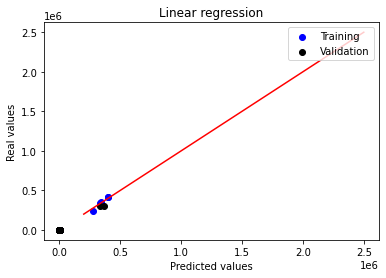

In [31]:
plt.scatter(train_pred, y_train, c = "blue",  label = "Training")
plt.scatter(test_pred, y_test, c = "black",  label = "Validation")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper right")
plt.plot([0.2*10**6, 0.25*10**7], [0.2*10**6, 0.25*10**7], c = "red")
plt.show()

## Artificial Neural Network

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.00001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=100)

Epoch 1/100
862/862 [==============================] - 2s 1ms/step - loss: 746040704.0000 - val_loss: 843616704.0000
Epoch 2/100
862/862 [==============================] - 1s 1ms/step - loss: 746042368.0000 - val_loss: 843616704.0000
Epoch 3/100
862/862 [==============================] - 1s 1ms/step - loss: 746042880.0000 - val_loss: 843616576.0000
Epoch 4/100
862/862 [==============================] - 1s 1ms/step - loss: 746042816.0000 - val_loss: 843616384.0000
Epoch 5/100
862/862 [==============================] - 1s 1ms/step - loss: 746042560.0000 - val_loss: 843616384.0000
Epoch 6/100
862/862 [==============================] - 1s 1ms/step - loss: 746041728.0000 - val_loss: 843616192.0000
Epoch 7/100
862/862 [==============================] - 1s 1ms/step - loss: 746042432.0000 - val_loss: 843616000.0000
Epoch 8/100
862/862 [==============================] - 1s 1ms/step - loss: 746041216.0000 - val_loss: 843615808.0000
Epoch 9/100
862/862 [==============================] - 1s 1ms/st

In [33]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test evaluation')
evaluate(y_test, test_pred, "Artificial Neural Network")

Test evaluation
MAE: 2901.3191105880737
MSE: 843027883.2881826
RMSE: 29034.942453674375
R2 Square -0.009779144547211516


## Comparativa

In [34]:
df_statistics

,Model,MAE,MSE,RMSE,R2 Square
0,Lineal regression,1118.582913,1.694141e+08,13015.918800,0.797076
1,Support Vector Machine - linear,1060.546511,1.993522e+08,14119.212294,0.761216
2,Support Vector Machine - poly,4234.361037,3.074259e+09,55446.003656,-2.682349
3,Random Forest,519.710926,2.289911e+07,4785.301250,0.972571
4,Artificial Neural Network,2901.319111,8.430279e+08,29034.942454,-0.009779


Como se puede observar el modelo que mejores resultados obtiene es el random forest

## Guardado del modelo

Una vez elegido el modelo, se guarda en un fichero para luego ser utilizado en el script, para ello se utiliza la libreria joblib

In [35]:
import joblib
joblib.dump(rf_reg, "random_forest.joblib", compress=3)


['random_forest.joblib']

In [50]:
loaded_rf = joblib.load("random_forest.joblib")
test = cleandf[['Current Portion of Long-Term Debt', 'Cash Flow per Share']]
pred = loaded_rf.predict(test)


In [51]:
data = cleandf[['Company Name', 'Next year price']]
data['Predicted'] = pred

data.to_csv("predict.csv")

<ipython-input-51-8b691c586a79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted'] = pred
